In [1]:
# Add parent directory to Python path for module imports
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt

from dataset_params import DatasetParams
from config import MOBILE_DEPTH
import dataset_loader
import utils
import initialization
import coordinate_descent

/home/holly/Documents/depth-from-defocus/dfd/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Found at: /home/holly/Documents/depth-from-defocus/dfd/data/MobileDepth/aligned-focus-stack/Aligned/Figure5/bottles


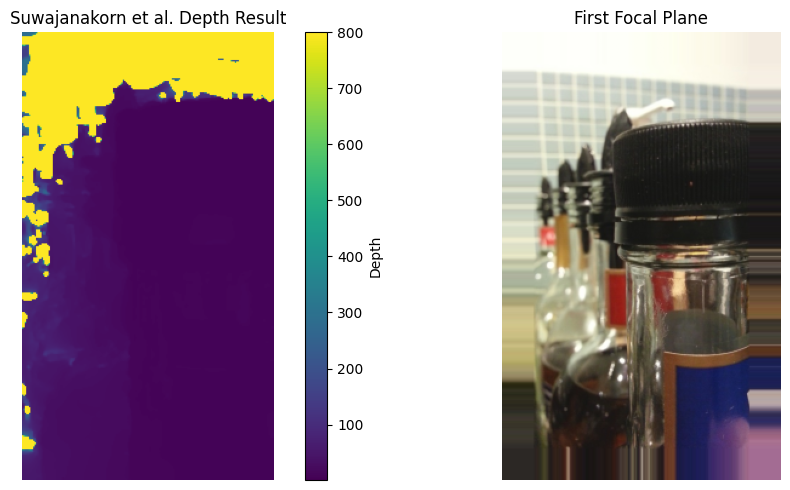

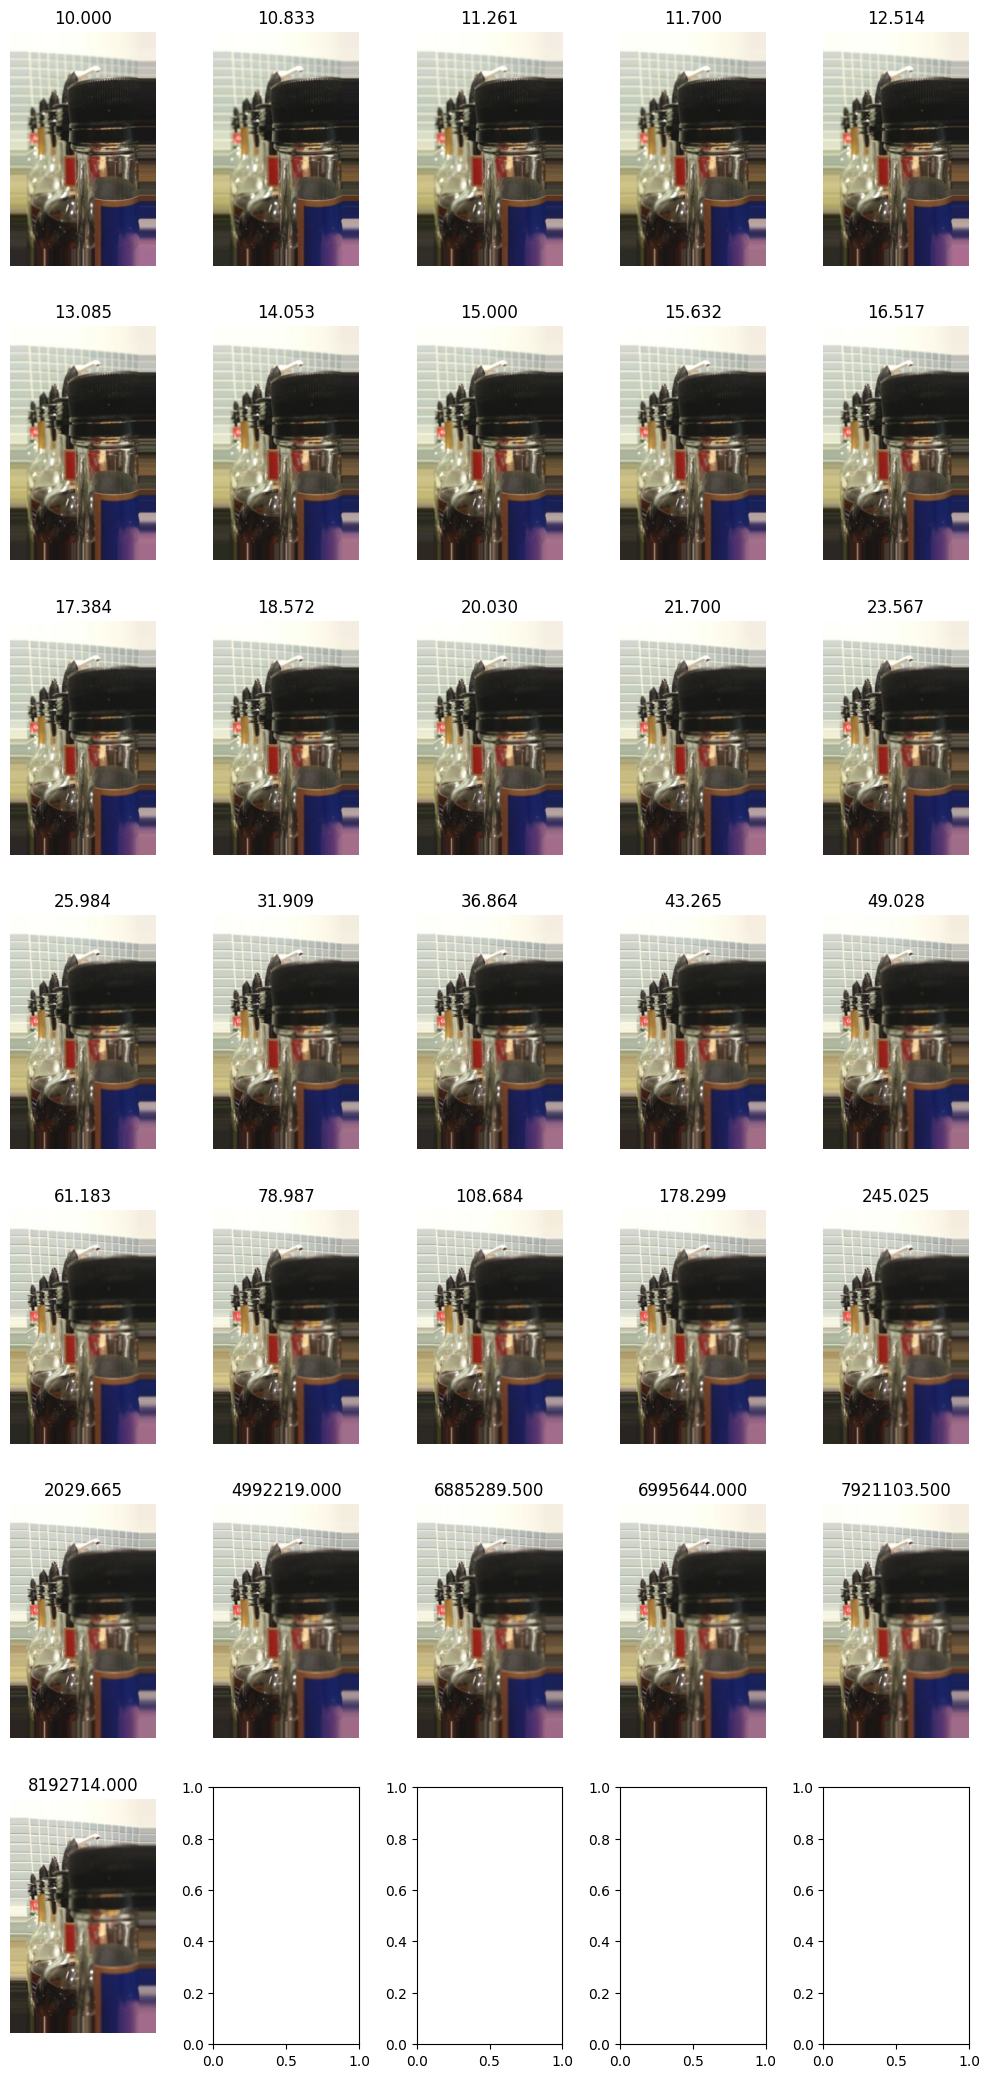

Image dimensions: 370 x 230 (padded)
Adaptive kernel size: 13


In [2]:
# Initialize MobileDepth dataset configuration
dataset_params = DatasetParams.for_MobileDepth()
config = MOBILE_DEPTH

example_name = "bottles"

# Load defocus stack from dataset (sets Df, f, D on dataset_params)
defocus_stack, dpt_result, scale_mat = dataset_loader.load_single_sample_MobileDepth(
    example_name, dataset_params, res="half", data_dir=config.data_dir
)

# Apply edge padding based on window size
rad = config.window_size // 2
defocus_stack = np.stack([
    np.pad(img, ((rad, rad), (rad, rad), (0, 0)), mode='edge')
    for img in defocus_stack
], axis=0)

# Visualize calibration depth result
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(dpt_result, vmin=dataset_params.min_Z, vmax=dataset_params.max_Z)
plt.title('Suwajanakorn et al. Depth Result')
plt.colorbar(label='Depth')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(defocus_stack[0] / 255.)
plt.title('First Focal Plane')
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize the full defocus stack
utils.plot_single_stack(defocus_stack / 255., dataset_params.Df)

# Print image dimensions
_, width, height, _ = defocus_stack.shape
print(f'Image dimensions: {width} x {height} (padded)')

# Set adaptive kernel size based on image dimensions
max_kernel_size = utils.kernel_size_heuristic(width, height)
print(f'Adaptive kernel size: {max_kernel_size}')

In [3]:
# Validate dataset params and config
print("=== Dataset Params (MobileDepth) ===")
print(f"  f  (focal length):  {dataset_params.f}")
print(f"  D  (aperture dia):  {dataset_params.D}")
print(f"  Df (focus dists):   {dataset_params.Df}")
print(f"  ps (pixel size):    {dataset_params.ps}")
print(f"  min_Z:              {dataset_params.min_Z}")
print(f"  max_Z:              {dataset_params.max_Z}")
print(f"  thresh:             {dataset_params.thresh}")

print("\n=== Config (MobileDepthConfig) ===")
print(f"  data_dir:           {config.data_dir}")
print(f"  num_epochs:         {config.num_epochs}")
print(f"  num_z:              {config.num_z}")
print(f"  t_0:                {config.t_0}")
print(f"  alpha:              {config.alpha}")
print(f"  nesterov_first:     {config.nesterov_first}")
print(f"  use_windowed_mse:   {config.use_windowed_mse}")
print(f"  window_size:        {config.window_size}")
print(f"  aif_lambda:         {config.aif_lambda}")
print(f"  aif_sharpness:      {config.aif_sharpness_measure}")
print(f"  experiment_folder:  {config.experiment_folder}")

print("\n=== Runtime ===")
print(f"  max_kernel_size:    {max_kernel_size}")
print(f"  stack shape:        {defocus_stack.shape}")
print(f"  num focal planes:   {defocus_stack.shape[0]}")
print(f"  stack range:        [{defocus_stack.min():.4f}, {defocus_stack.max():.4f}]")
print(f"  dpt_result shape:   {dpt_result.shape}")

=== Dataset Params (MobileDepth) ===
  f  (focal length):  2.0
  D  (aperture dia):  21.738576
  Df (focus dists):   [1.0000000e+01 1.0832749e+01 1.1261277e+01 1.1700458e+01 1.2514304e+01
 1.3084701e+01 1.4052573e+01 1.5000034e+01 1.5631887e+01 1.6516647e+01
 1.7384253e+01 1.8571783e+01 2.0030046e+01 2.1700497e+01 2.3566650e+01
 2.5983974e+01 3.1909075e+01 3.6864040e+01 4.3264957e+01 4.9028160e+01
 6.1182655e+01 7.8987030e+01 1.0868426e+02 1.7829900e+02 2.4502525e+02
 2.0296646e+03 4.9922190e+06 6.8852895e+06 6.9956440e+06 7.9211035e+06
 8.1927140e+06]
  ps (pixel size):    1.5
  min_Z:              1
  max_Z:              800
  thresh:             0.1

=== Config (MobileDepthConfig) ===
  data_dir:           data
  num_epochs:         5
  num_z:              200
  t_0:                10
  alpha:              2.0
  nesterov_first:     False
  use_windowed_mse:   True
  window_size:        50
  aif_lambda:         0.05
  aif_sharpness:      sobel_grad
  experiment_folder:  experiments/m

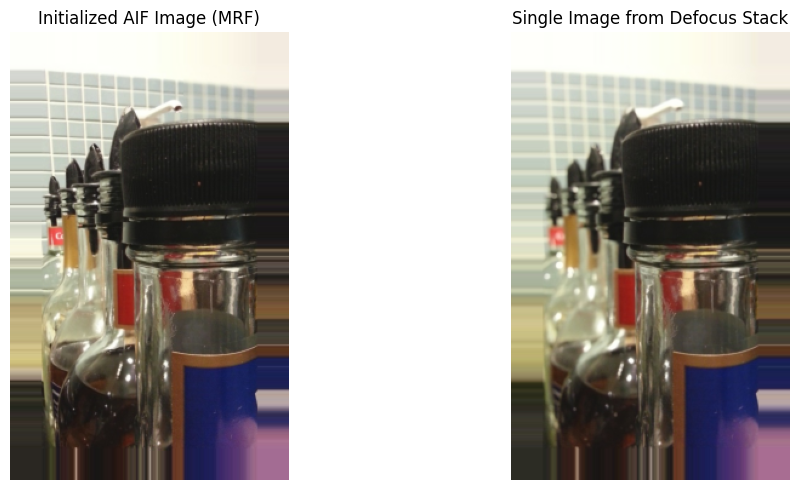

AIF initialization complete!


In [4]:
# Compute AIF initialization using MRF optimization
# - lmbda: controls tradeoff between data and smoothness terms
# - sharpness_measure: method for computing sharpness ('sobel_grad', 'laplacian', 'log')
aif_init = initialization.compute_aif_initialization(
    defocus_stack,
    lmbda=config.aif_lambda,
    sharpness_measure=config.aif_sharpness_measure
)

# Visualize initialized AIF and compare to one image from the stack
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(aif_init / 255.)
plt.title('Initialized AIF Image (MRF)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(defocus_stack[1] / 255.)
plt.title('Single Image from Defocus Stack')
plt.axis('off')

plt.tight_layout()
plt.show()

print('AIF initialization complete!')

Starting coordinate descent optimization...

Depth range: [ 1 - 800 ]
Created experiment folder: /home/holly/Documents/depth-from-defocus/dfd/experiments/mobiledepth/mobile-depth-windowed50-bottles_2026-02-14_00-03-09
Images in range [0-255]


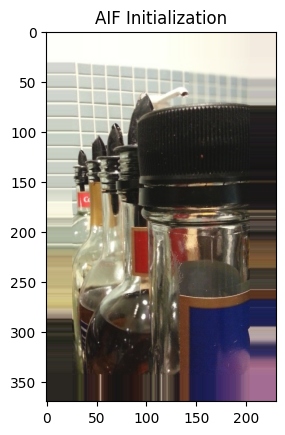

Iteration 0 



Grid search         :   1%|▏                    | 2/200 [00:03<05:09,  1.56s/it]

In [ ]:
# Run coordinate descent optimization
print('Starting coordinate descent optimization...\n')

dpt, aif, _, experiment_folder = coordinate_descent.coordinate_descent(
    defocus_stack,
    # Camera/scene params (focal length, aperture, focus distances, depth range, etc.)
    dataset_params,
    # Max blur kernel size (controls forward model resolution)
    max_kernel_size,
    # Optimization parameters
    num_epochs=config.num_epochs,
    num_Z=config.num_z,
    T_0=config.t_0,
    alpha=config.alpha,
    nesterov_first=config.nesterov_first,
    # Initialization
    aif_init=aif_init,
    # Windowed MSE (used for outdoor scenes with large depth range)
    windowed_mse=config.use_windowed_mse,
    window_size=config.window_size,
    # Visualization
    experiment_folder=config.experiment_folder,
    experiment_name=config.get_experiment_name(example_name),
    show_plots=True,
    save_plots=True,
    verbose=True
)

print('\nOptimization complete!')

In [ ]:
# Visualize reconstructed AIF image and depth map (cropped to remove padding)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(aif[rad:-rad, rad:-rad] / 255.)
plt.title('Reconstructed All-in-Focus Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dpt[rad:-rad, rad:-rad], vmin=dataset_params.min_Z, vmax=dataset_params.max_Z)
plt.title('Reconstructed Depth Map')
plt.colorbar(label='Depth')
plt.axis('off')
plt.tight_layout()
plt.show()

# # Remove outliers using total variation filtering
# dpt_cleaned, _ = outlier_removal.remove_outliers(
#     dpt.copy(), aif, max_kernel_size,
#     patch_type='tv', tv_thresh=25, to_plot=True
# )

# # Compare depth maps before and after outlier removal
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(dpt[rad:-rad, rad:-rad], vmin=dataset_params.min_Z, vmax=dataset_params.max_Z)
# plt.title('Depth Map (Before Outlier Removal)')
# plt.colorbar(label='Depth')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(dpt_cleaned[rad:-rad, rad:-rad], vmin=dataset_params.min_Z, vmax=dataset_params.max_Z)
# plt.title('Depth Map (After Outlier Removal)')
# plt.colorbar(label='Depth')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

# print(f'Depth range: [{dataset_params.min_Z}, {dataset_params.max_Z}]')